In [1]:
! nvidia-smi

Fri Jul  7 17:52:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone https://github.com/nanekja/pytorch_utils

Cloning into 'pytorch_utils'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 114 (delta 67), reused 78 (delta 33), pack-reused 0
Receiving objects: 100% (114/114), 17.70 KiB | 8.85 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [3]:
from __future__ import print_function

import torch
import torch.optim as optim
import torchvision
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, OneCycleLR

!pip install albumentations
!pip install torchsummary
!pip install tqdm
!pip install torchinfo torch_lr_finder

import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt

sys.path.append('./pytorch_utils/')
import main
import utils
import transform
import custom_resnet
import train1
import test1
import dataloader
import albumentation


/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


100%|██████████| 170498071/170498071 [00:12<00:00, 13158118.28it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
device = utils.get_device()
print(device)

cuda


In [5]:
mean, std = utils.get_mean_and_std()

Files already downloaded and verified
 - Dataset Numpy Shape: (50000, 32, 32, 3)
 - Min: [0. 0. 0.]
 - Max: [1. 1. 1.]
 - Mean: [0.49139968 0.48215841 0.44653091]
 - Std: [0.24703223 0.24348513 0.26158784]
 - Var: [15.56135559 15.11767693 17.44919073]


Files already downloaded and verified


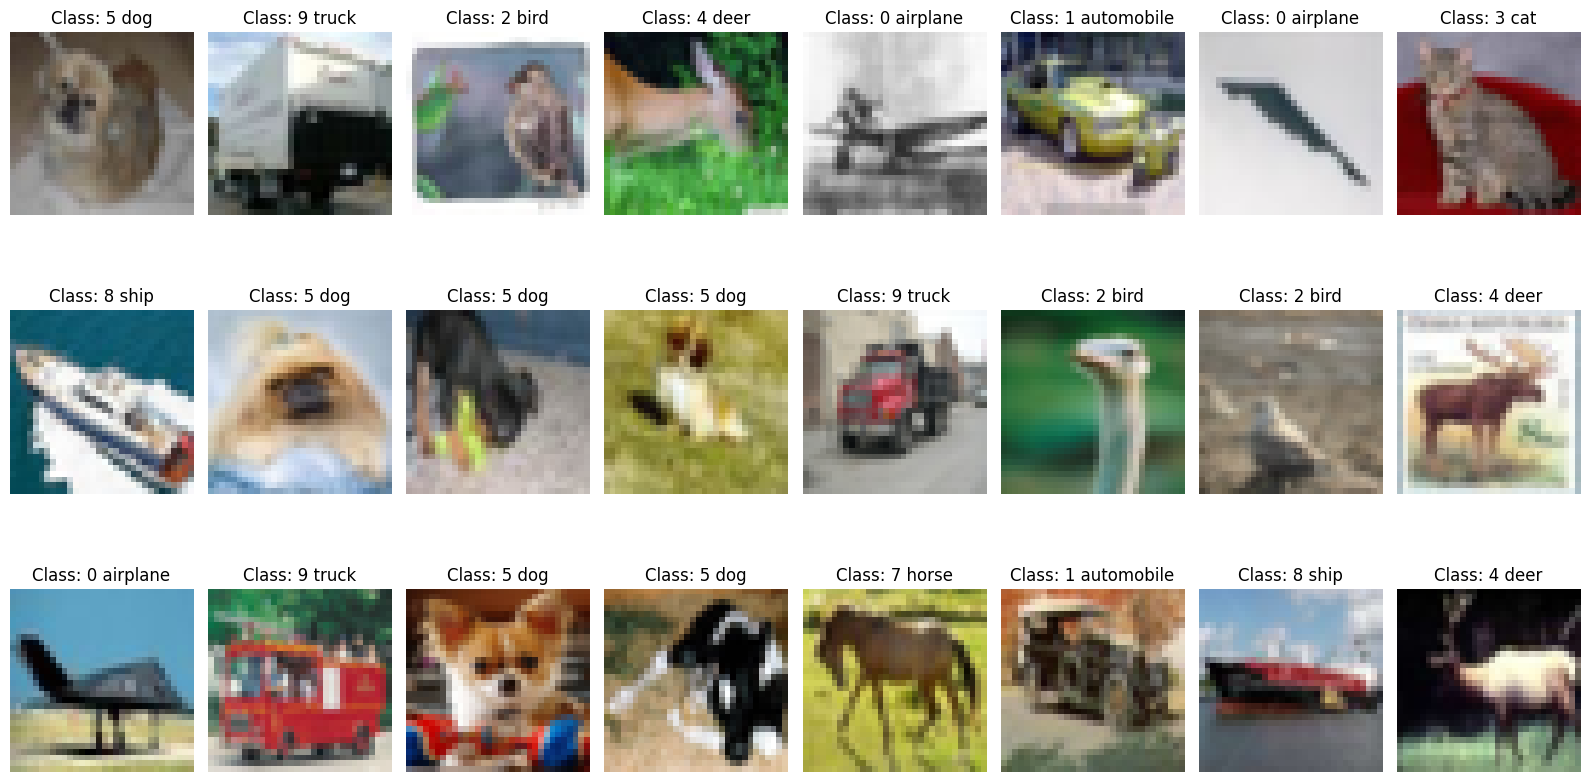

In [6]:
exp = torchvision.datasets.CIFAR10('./data', train=True, download=True)
utils.plot_data(exp,3,8)

torch.Size([512, 3, 32, 32])
torch.Size([512])


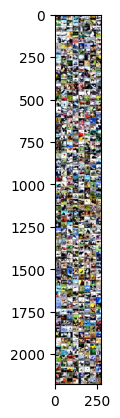

In [7]:
dataiter = iter(transform.train_loader)

images, labels = next(dataiter)
print(images.shape)
print(labels.shape)

# show images
utils.imshow(torchvision.utils.make_grid(images))


In [8]:
from custom_resnet import Net
model = Net().to(device)

!pip install torchscan --no-deps
from torchscan import summary

summary(model, (3, 32, 32), receptive_field=True, max_depth=1)

_______________________________________________________________________________
Layer           Type          Output Shape         Param #      Receptive field
net             Net           (-1, 10)             0            1              
├─prep_layer    Sequential    (-1, 64, 32, 32)     1,985        3              
├─layer1        Sequential    (-1, 128, 16, 16)    74,241       6              
├─resblock1     Sequential    (-1, 128, 16, 16)    295,938      14             
├─layer2        Sequential    (-1, 256, 8, 8)      295,937      20             
├─layer3        Sequential    (-1, 512, 4, 4)      1,181,697    32             
├─resblock2     Sequential    (-1, 512, 4, 4)      4,722,690    64             
├─pool          MaxPool2d     (-1, 512, 1, 1)      0            88             
├─fc            Linear        (-1, 10)             5,120        88             
Trainable params: 6,573,120
Non-trainable params: 0
Total params: 6,573,120
--------------------------------------------

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/400 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.32E-03


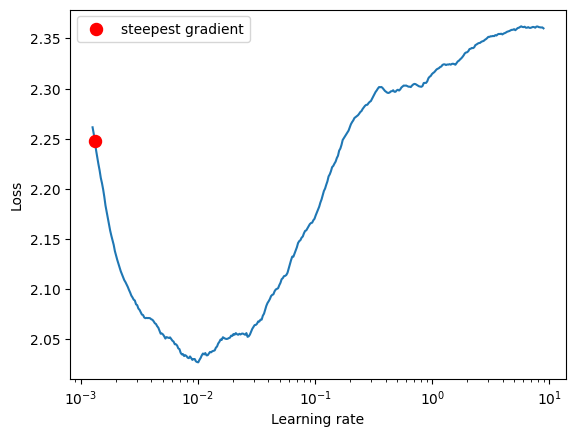

In [9]:
lrmax=0.001
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=lrmax)

utils.find_lr(model, optimizer, criterion, transform.train_loader)

In [10]:
#Train again with one cycle policy now
EPOCHS = 24
max_epoch=5

scheduler = OneCycleLR(optimizer=optimizer, max_lr=lrmax, epochs=EPOCHS, steps_per_epoch=len(transform.train_loader), pct_start=max_epoch/EPOCHS, verbose = False, div_factor=10, three_phase = False, base_momentum = 0.5)

In [11]:
net, history = main.fit_model(model, device, transform.train_loader, transform.test_loader, optimizer, criterion, scheduler, EPOCHS)

EPOCH: 1 (LR: 0.00010000000000000005)


Batch_id=97 Loss=2.04435 Accuracy=42.10: 100%|██████████| 98/98 [00:23<00:00,  4.21it/s]



Test set: Average loss: -0.5005, Accuracy: 5229/10000 (52.29%)

EPOCH: 2 (LR: 0.00018628251465039822)


Batch_id=97 Loss=1.89196 Accuracy=57.57: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: -0.6013, Accuracy: 6172/10000 (61.72%)

EPOCH: 3 (LR: 0.0004120426260042767)


Batch_id=97 Loss=1.81575 Accuracy=64.99: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]



Test set: Average loss: -0.6859, Accuracy: 7009/10000 (70.09%)

EPOCH: 4 (LR: 0.0006907063335488948)


Batch_id=97 Loss=1.76131 Accuracy=70.41: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s]



Test set: Average loss: -0.6984, Accuracy: 7107/10000 (71.07%)

EPOCH: 5 (LR: 0.0009154122798231293)


Batch_id=97 Loss=1.72450 Accuracy=74.05: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]



Test set: Average loss: -0.7160, Accuracy: 7247/10000 (72.47%)

EPOCH: 6 (LR: 0.000999999288334431)


Batch_id=97 Loss=1.69291 Accuracy=77.09: 100%|██████████| 98/98 [00:20<00:00,  4.76it/s]



Test set: Average loss: -0.7618, Accuracy: 7737/10000 (77.37%)

EPOCH: 7 (LR: 0.00099304116623315)


Batch_id=97 Loss=1.66772 Accuracy=79.66: 100%|██████████| 98/98 [00:21<00:00,  4.51it/s]



Test set: Average loss: -0.7584, Accuracy: 7659/10000 (76.59%)

EPOCH: 8 (LR: 0.0009726343027663911)


Batch_id=97 Loss=1.64983 Accuracy=81.48: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: -0.7641, Accuracy: 7682/10000 (76.82%)

EPOCH: 9 (LR: 0.0009393353439728048)


Batch_id=97 Loss=1.63859 Accuracy=82.53: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]



Test set: Average loss: -0.8131, Accuracy: 8193/10000 (81.93%)

EPOCH: 10 (LR: 0.0008940525986443731)


Batch_id=97 Loss=1.62310 Accuracy=84.11: 100%|██████████| 98/98 [00:22<00:00,  4.27it/s]



Test set: Average loss: -0.8203, Accuracy: 8247/10000 (82.47%)

EPOCH: 11 (LR: 0.0008380212620303486)


Batch_id=97 Loss=1.61258 Accuracy=85.15: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: -0.8541, Accuracy: 8615/10000 (86.15%)

EPOCH: 12 (LR: 0.0007727697229307684)


Batch_id=97 Loss=1.59876 Accuracy=86.54: 100%|██████████| 98/98 [00:21<00:00,  4.52it/s]



Test set: Average loss: -0.8301, Accuracy: 8346/10000 (83.46%)

EPOCH: 13 (LR: 0.0007000778732342018)


Batch_id=97 Loss=1.58948 Accuracy=87.45: 100%|██████████| 98/98 [00:21<00:00,  4.50it/s]



Test set: Average loss: -0.8509, Accuracy: 8552/10000 (85.52%)

EPOCH: 14 (LR: 0.0006219285571068613)


Batch_id=97 Loss=1.58246 Accuracy=88.22: 100%|██████████| 98/98 [00:20<00:00,  4.78it/s]



Test set: Average loss: -0.8591, Accuracy: 8639/10000 (86.39%)

EPOCH: 15 (LR: 0.0005404534841726384)


Batch_id=97 Loss=1.57242 Accuracy=89.19: 100%|██████████| 98/98 [00:21<00:00,  4.55it/s]



Test set: Average loss: -0.8499, Accuracy: 8547/10000 (85.47%)

EPOCH: 16 (LR: 0.0004578750820315145)


Batch_id=97 Loss=1.56093 Accuracy=90.38: 100%|██████████| 98/98 [00:21<00:00,  4.61it/s]



Test set: Average loss: -0.8851, Accuracy: 8908/10000 (89.08%)

EPOCH: 17 (LR: 0.00037644587422807144)


Batch_id=97 Loss=1.55363 Accuracy=91.07: 100%|██████████| 98/98 [00:21<00:00,  4.65it/s]



Test set: Average loss: -0.8858, Accuracy: 8904/10000 (89.04%)

EPOCH: 18 (LR: 0.0002983870372810847)


Batch_id=97 Loss=1.54770 Accuracy=91.63: 100%|██████████| 98/98 [00:22<00:00,  4.45it/s]



Test set: Average loss: -0.8886, Accuracy: 8936/10000 (89.36%)

EPOCH: 19 (LR: 0.0002258278127782669)


Batch_id=97 Loss=1.54064 Accuracy=92.39: 100%|██████████| 98/98 [00:21<00:00,  4.47it/s]



Test set: Average loss: -0.8956, Accuracy: 8992/10000 (89.92%)

EPOCH: 20 (LR: 0.00016074742721627382)


Batch_id=97 Loss=1.53635 Accuracy=92.80: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]



Test set: Average loss: -0.9011, Accuracy: 9048/10000 (90.48%)

EPOCH: 21 (LR: 0.00010492110386133256)


Batch_id=97 Loss=1.53087 Accuracy=93.39: 100%|██████████| 98/98 [00:21<00:00,  4.57it/s]



Test set: Average loss: -0.9042, Accuracy: 9086/10000 (90.86%)

EPOCH: 22 (LR: 5.987163928620278e-05)


Batch_id=97 Loss=1.52819 Accuracy=93.68: 100%|██████████| 98/98 [00:21<00:00,  4.62it/s]



Test set: Average loss: -0.9051, Accuracy: 9098/10000 (90.98%)

EPOCH: 23 (LR: 2.6827865449304146e-05)


Batch_id=97 Loss=1.52583 Accuracy=93.84: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]



Test set: Average loss: -0.9046, Accuracy: 9084/10000 (90.84%)

EPOCH: 24 (LR: 6.691130362217893e-06)


Batch_id=97 Loss=1.52535 Accuracy=93.96: 100%|██████████| 98/98 [00:21<00:00,  4.51it/s]



Test set: Average loss: -0.9047, Accuracy: 9082/10000 (90.82%)



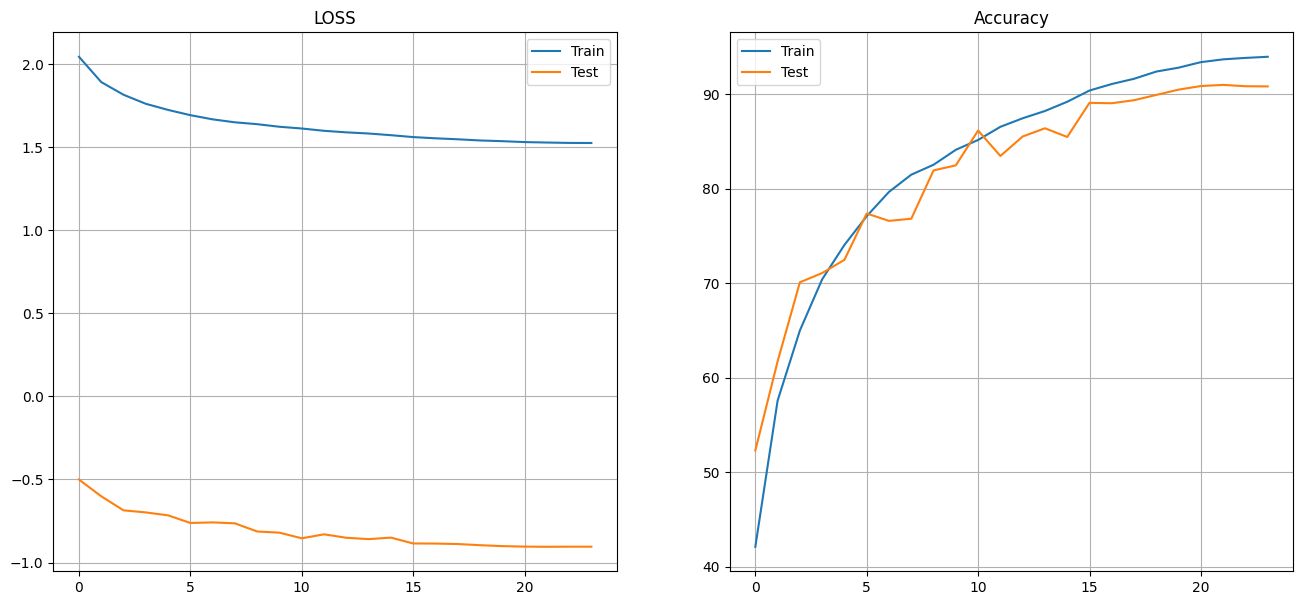

In [12]:
utils.result_graphs(history)

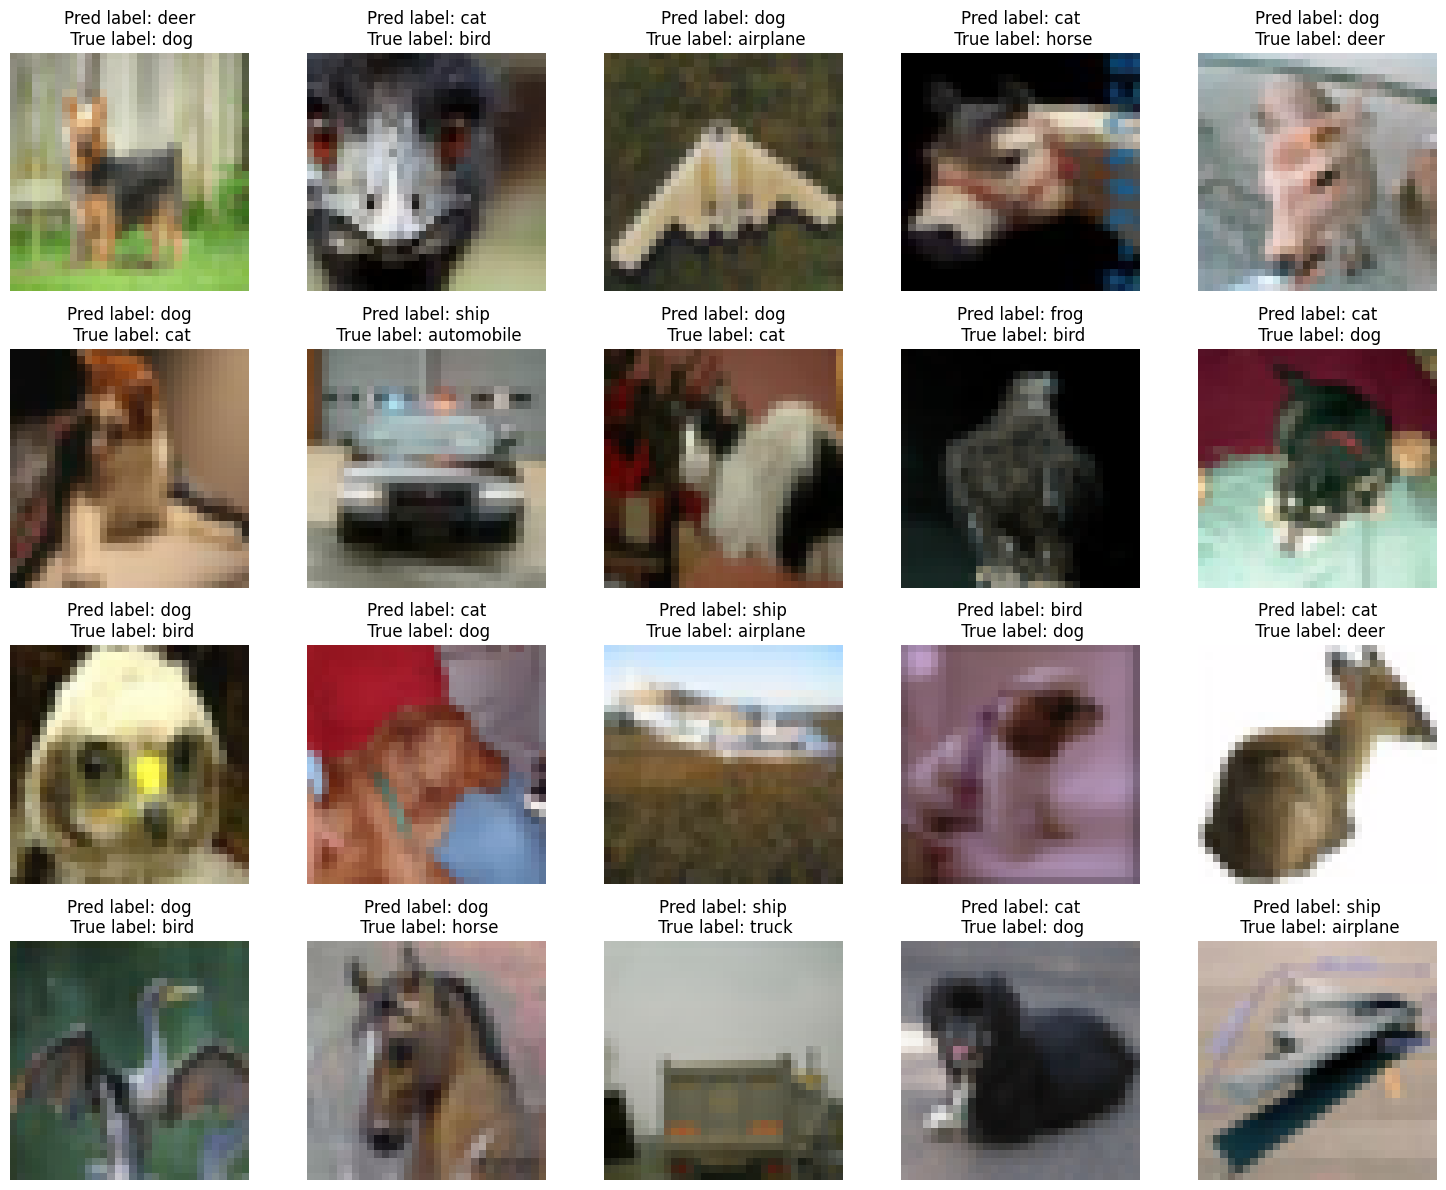

In [13]:
misclf = utils.plot_misclassified(net, transform.test_loader, transform.testset.classes, device, mean, std, return_misclf=True)